## Multi-label prediction with Planet Amazon dataset

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *

In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


## Getting the data

The planet dataset isn't available on the [fastai dataset page](https://course.fast.ai/datasets) due to copyright restrictions. You can download it from Kaggle however. Let's see how to do this by using the [Kaggle API](https://github.com/Kaggle/kaggle-api) as it's going to be pretty useful to you if you want to join a competition or use other Kaggle datasets later on.

First, install the Kaggle API by uncommenting the following line and executing it, or by executing it in your terminal (depending on your platform you may need to modify this slightly to either add `source activate fastai` or similar, or prefix `pip` with a path. Have a look at how `conda install` is called for your platform in the appropriate *Returning to work* section of https://course.fast.ai/. (Depending on your environment, you may also need to append "--user" to the command.)

In [0]:
# ! {sys.executable} -m pip install kaggle --upgrade

Then you need to upload your credentials from Kaggle on your instance. Login to kaggle and click on your profile picture on the top left corner, then 'My account'. Scroll down until you find a button named 'Create New API Token' and click on it. This will trigger the download of a file named 'kaggle.json'.

Upload this file to the directory this notebook is running in, by clicking "Upload" on your main Jupyter page, then uncomment and execute the next two commands (or run them in a terminal). For Windows, uncomment the last two commands.

In [0]:
! mkdir -p ~/.kaggle/
! mv kaggle.json ~/.kaggle/

# For Windows, uncomment these two commands
# ! mkdir %userprofile%\.kaggle
# ! move kaggle.json %userprofile%\.kaggle

You're all set to download the data from [planet competition](https://www.kaggle.com/c/planet-understanding-the-amazon-from-space). You **first need to go to its main page and accept its rules**, and run the two cells below (uncomment the shell commands to download and unzip the data). If you get a `403 forbidden` error it means you haven't accepted the competition rules yet (you have to go to the competition page, click on *Rules* tab, and then scroll to the bottom to find the *accept* button).

In [0]:
path = Path(base_dir + 'planet/data')

# path = Config.data_path()/'planet'
# path.mkdir(parents=True, exist_ok=True)
# path

In [0]:
path

PosixPath('/content/gdrive/My Drive/fastai-v3/planet/data')

In [0]:
# !kaggle competitions download -c planet-understanding-the-amazon-from-space -f train-jpg.tar.7z -p /content/gdrive/My\ Drive/fastai-v3/planet/data
# ! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train_v2.csv -p /content/gdrive/My\ Drive/fastai-v3/planet/data

 99% 597M/600M [00:05<00:00, 118MB/s]
100% 600M/600M [00:05<00:00, 111MB/s]


In [0]:
# ! unzip -q -n /content/gdrive/My\ Drive/fastai-v3/planet/data/train_v2.csv.zip -d /content/gdrive/My\ Drive/fastai-v3/planet/data

In [0]:
# ! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train-jpg.tar.7z -p {path}  
# ! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train_v2.csv -p {path}  
# ! unzip -q -n {path}/train_v2.csv.zip -d {path}

404 - Not Found
404 - Not Found
unzip:  cannot find or open /content/gdrive/My, /content/gdrive/My.zip or /content/gdrive/My.ZIP.


To extract the content of this file, we'll need 7zip, so uncomment the following line if you need to install it (or run `sudo apt install p7zip-full` in your terminal).

In [0]:
# ! conda install --yes --prefix {sys.prefix} -c haasad eidl7zip

/bin/bash: conda: command not found


In [0]:
# ! 7za x /content/gdrive/My\ Drive/fastai-v3/planet/data/train-jpg.tar.7z


7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/gdrive/My Drive/fastai-v3/planet/data/                                                         1 file, 629296207 bytes (601 MiB)

Extracting archive: /content/gdrive/My Drive/fastai-v3/planet/data/train-jpg.tar.7z
--
Path = /content/gdrive/My Drive/fastai-v3/planet/data/train-jpg.tar.7z
Type = 7z
Physical Size = 629296207
Headers Size = 98
Method = LZMA2:24
Solid = -
Blocks = 1

  0%      0% - train-jpg.tar                      1% - train-jpg.tar                      2% - train-jpg.tar                    

And now we can unpack the data (uncomment to run - this might take a few minutes to complete).

## Multiclassification

Each picture can have multiple labels. 

Hence we can't have different folders for each label.

The csv file contains the labels and each image is associated with several tags.

In [0]:
df = pd.read_csv(path/'train_v2.csv')
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


We need a 'DataBunch' object to feed into a model. We have been using various factory methods for the same (eg. from_name_re, from_folder etc).

Sometimes we need more flexibility, because there's so many choices to make.

The **data block API** lets you customize the creation of a DataBunch by isolating the underlying parts of that process in separate blocks, mainly:

*   Where are the inputs and how to create them?
*   How to split the data into a training and validation sets?
*   How to label the inputs?
*   What transforms to apply?
*   How to add a test set?
*   How to wrap in dataloaders and create the DataBunch? 

The data block API has separate methods for each of these decisions with their own parameters for every choice that we have to make on how to create / set up the data.


To put this in a `DataBunch` while using the [data block API](https://docs.fast.ai/data_block.html), we then need to using `ImageList` (and not `ImageDataBunch`). This will make sure the model created has the proper loss function to deal with the multiple classes.

In [0]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

**flip_vert** can be made 'True' for satellite images.

Perspective warping should be zero for satellite images.

We use parentheses around the data block pipeline below, so that we can use a multiline statement without needing to add '\\'.

In [0]:
np.random.seed(42)
src = (ImageList.from_csv(path, 'train_v2.csv', folder='train-jpg', suffix='.jpg')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=' '))

In [0]:
type(src)

fastai.data_block.LabelLists

In [0]:
data = (src.transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))

In [0]:
type(data)

fastai.vision.data.ImageDataBunch

`show_batch` still works, and show us the different labels separated by `;`.

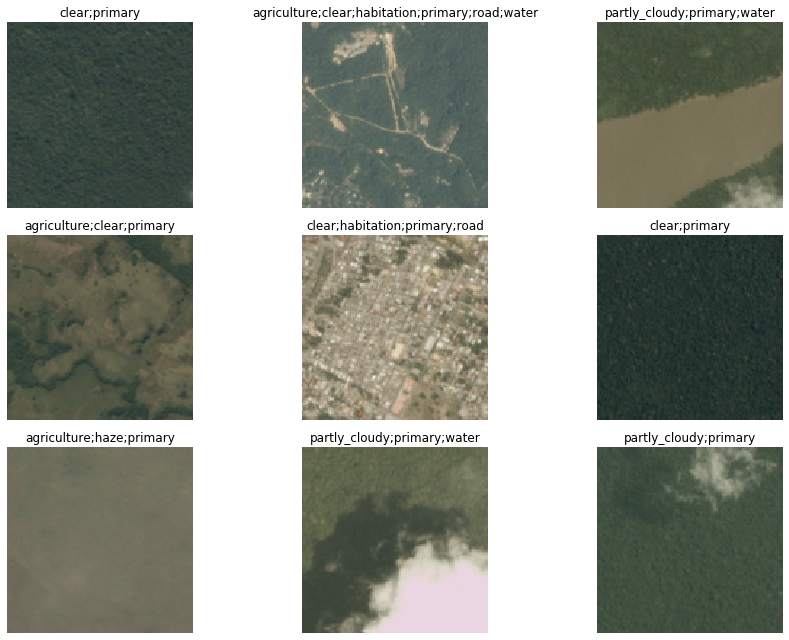

In [0]:
data.show_batch(rows=3, figsize=(12,9))

We create a `Learner` we use the same function as in lesson 1. 

Base architecture is resnet50.but the metrics are a little bit differeent: we use `accuracy_thresh` instead of `accuracy`. 

In lesson 1, we determined the prediction for a given class by picking the final activation that was the biggest (argmax), but here, each activation can be 0. or 1. 

`accuracy_thresh` selects the ones that are above a certain threshold (0.5 by default) and compares them to the ground truth.

Fbeta, it's the metric that was used by Kaggle on this competition. See [here](https://en.wikipedia.org/wiki/F1_score) for more details.

In [0]:
arch = models.resnet50

In [0]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = cnn_learner(data, arch, metrics=[acc_02, f_score])

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:02<00:00, 47.7MB/s]


We use the LR Finder to pick a good learning rate.

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


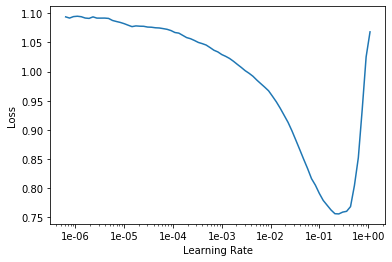

In [0]:
learn.recorder.plot()

Then we can fit the head of our network.

In [0]:
lr = 0.01

In [0]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.133633,0.116123,0.949242,0.900692,1:55:55
1,0.111912,0.105843,0.943378,0.897771,05:02
2,0.103842,0.092314,0.952062,0.920402,05:00
3,0.096252,0.088488,0.956814,0.923807,05:00
4,0.092095,0.087237,0.956473,0.924278,05:01


In [0]:
learn.save('stage-1-rn50')

In [0]:
learn.load('stage-1-rn50')

Learner(data=ImageDataBunch;

Train: LabelList (32384 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: MultiCategoryList
haze;primary,clear;primary,clear;primary,haze;primary;water,agriculture;clear;cultivation;primary;water
Path: /content/gdrive/My Drive/fastai-v3/planet/data;

Valid: LabelList (8095 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: MultiCategoryList
clear;primary;road,clear;primary;water,clear;conventional_mine;habitation;primary;road;water,cloudy,agriculture;clear;cultivation;cultivation;habitation;primary;road;water
Path: /content/gdrive/My Drive/fastai-v3/planet/data;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
   

...And fine-tune the whole model:

In [0]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


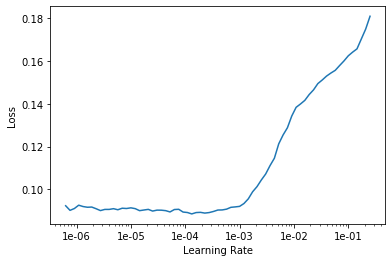

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.096133,0.092816,0.956102,0.919504,1:16:22
1,0.095975,0.090687,0.952963,0.922649,04:29
2,0.090007,0.086679,0.958682,0.926690,04:27
3,0.085119,0.082729,0.957868,0.929396,04:27
4,0.079569,0.082327,0.959038,0.929677,04:27


In [0]:
learn.save('stage-2-rn50')

Actual size was 256, we used 128 till now.

In [0]:
data = (src.transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 256, 256])

In [0]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


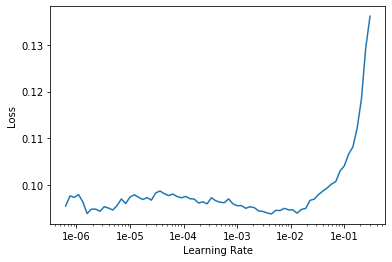

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
lr=1e-2/2

In [0]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.088585,0.085249,0.956015,0.926703,06:06
1,0.088380,0.083417,0.957396,0.928629,06:08
2,0.084848,0.083435,0.958173,0.928943,06:07
3,0.085460,0.082153,0.959336,0.930602,06:09
4,0.076886,0.081402,0.957650,0.930103,06:09


In [0]:
learn.save('stage-1-256-rn50')

In [0]:
learn.load('stage-1-256-rn50')

Learner(data=ImageDataBunch;

Train: LabelList (32384 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: MultiCategoryList
haze;primary,clear;primary,clear;primary,haze;primary;water,agriculture;clear;cultivation;primary;water
Path: /content/gdrive/My Drive/fastai-v3/planet/data;

Valid: LabelList (8095 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: MultiCategoryList
clear;primary;road,clear;primary;water,clear;conventional_mine;habitation;primary;road;water,cloudy,agriculture;clear;cultivation;cultivation;habitation;primary;road;water
Path: /content/gdrive/My Drive/fastai-v3/planet/data;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
   

In [0]:
learn.unfreeze()

In [0]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.086412,0.083407,0.955012,0.926866,1:45:24
1,0.085387,0.084117,0.956291,0.926081,06:28
2,0.085071,0.083150,0.958057,0.928334,06:28
3,0.081360,0.080870,0.960063,0.930981,06:27
4,0.073966,0.080667,0.959605,0.931090,06:28


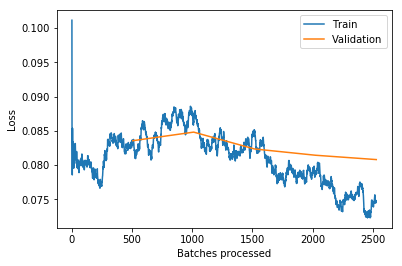

In [0]:
learn.recorder.plot_losses()

In [0]:
learn.save('stage-2-256-rn50')

You won't really know how you're going until you submit to Kaggle, since the leaderboard isn't using the same subset as we have for training. But as a guide, 50th place (out of 938 teams) on the private leaderboard was a score of `0.930`.

In [0]:
learn.export()

## fin

(This section will be covered in part 2 - please don't ask about it just yet! :) )

In [0]:
#! kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg.tar.7z -p {path}  
#! 7za -bd -y -so x {path}/test-jpg.tar.7z | tar xf - -C {path}
#! kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg-additional.tar.7z -p {path}  
#! 7za -bd -y -so x {path}/test-jpg-additional.tar.7z | tar xf - -C {path}

In [0]:
test = ImageList.from_folder(path/'test-jpg').add(ImageList.from_folder(path/'test-jpg-additional'))
len(test)

61191

In [0]:
learn = load_learner(path, test=test)
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [0]:
thresh = 0.2
labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(pred) if p > thresh]) for pred in preds]

In [0]:
labelled_preds[:5]

['agriculture cultivation partly_cloudy primary road',
 'clear haze primary water',
 'agriculture clear cultivation primary',
 'clear primary',
 'partly_cloudy primary']

In [0]:
fnames = [f.name[:-4] for f in learn.data.test_ds.items]

In [0]:
df = pd.DataFrame({'image_name':fnames, 'tags':labelled_preds}, columns=['image_name', 'tags'])

In [0]:
df.to_csv(path/'submission.csv', index=False)

In [0]:
! kaggle competitions submit planet-understanding-the-amazon-from-space -f {path/'submission.csv'} -m "My submission"

100%|██████████████████████████████████████| 2.18M/2.18M [00:02<00:00, 1.05MB/s]
Successfully submitted to Planet: Understanding the Amazon from Space

Private Leaderboard score: 0.9296 (around 80th)